# Índice

1. [Herramientas para la Manipulación y Análisis de Datos](#herramientas-para-la-manipulación-y-analisis-de-datos)
2. [Carga del Conjunto de Datos](#carga-del-conjunto-de-datos)
3. [Identificación de Valores Nulos Iniciales](#identificacion-de-valores-nulos-iniciales)
4. [Rango Intercuartílico (IQR)](#Rango-Intercuartílico-(IQR))
5. [Tramatamiento de los datos](#Tramatamiento-de-los-datos)
6. [Definición de Predictores y Objetivos](#Definición-de-Predictores-y-Objetivos)
7. [Normalización y Separación de los Datos](#Normalización-y-Separación-de-los-Datos)
8. [Definición y Configuración de los Modelos](#Definición-y-Configuración-de-los-Modelos)
9. [Optimización, Evaluación y Comparación de Modelos](#optimización-evaluación-y-comparación-de-modelos)
10. [Conversión de Resultados a un DataFrame](#Conversión-de-Resultados-a-un-DataFrame)
11. [Conclusión final](#Conclusión-final)


### **Herramientas para la Manipulación y Análisis de Datos**

Se incluyen bibliotecas para manejar datos estructurados y realizar cálculos numéricos:
- **Pandas**: Permite cargar, explorar, limpiar y transformar datos tabulares.
- **NumPy**: Proporciona soporte para cálculos matemáticos avanzados y manipulación de arrays.

### Visualización de Datos

Las bibliotecas para graficar y explorar patrones son:
- **Seaborn**: Facilita la creación de gráficos estadísticos con un diseño atractivo.
- **Matplotlib**: Ofrece herramientas flexibles para personalizar gráficos y visualizaciones.

### Preparación de Datos

Se incluyen herramientas esenciales para el preprocesamiento:
- **División de Datos**: Se separan en conjuntos de entrenamiento y prueba, garantizando una evaluación imparcial de los modelos.
- **Escalado de Características**: La normalización asegura que las variables numéricas tengan un rango uniforme, mejorando la estabilidad de los modelos.
- **Detección de Valores Atípicos**: Se puede realizar mediante métodos como el cálculo del *z-score* para identificar observaciones fuera de lo común.

### Modelos de Regresión

El código soporta múltiples algoritmos de regresión, desde los más básicos hasta los avanzados:
- **Regresión Lineal**: Modelo sencillo para identificar relaciones lineales entre variables.
- **Árboles de Decisión**: Segmentan los datos en reglas jerárquicas y fáciles de interpretar.
- **Bosques Aleatorios**: Combinan múltiples árboles para mejorar la precisión mediante promediado.
- **Gradient Boosting**: Modelo iterativo que optimiza la predicción acumulando errores de modelos más pequeños.
- **Máquinas de Soporte Vectorial (SVR)**: Capturan relaciones complejas y no lineales.
- **Regresión con Redes Neuronales (MLPRegressor)**: Utiliza redes neuronales multicapa para capturar patrones complejos en los datos.
- **XGBoost**: Algoritmo avanzado basado en árboles de decisión, conocido por su eficiencia y alto rendimiento.

### Ajuste de Hiperparámetros

- **Búsqueda en Grilla (GridSearchCV)**: Técnica que evalúa combinaciones de hiperparámetros para encontrar la configuración óptima de un modelo.

### Evaluación del Modelo

Para medir el desempeño de los modelos, se utilizan métricas clave:
- **Error Cuadrático Medio (MSE)**: Calcula la diferencia promedio al cuadrado entre valores reales y predichos.
- **Coeficiente de Determinación (R²)**: Indica la proporción de variabilidad en los datos explicada por el modelo.

### Configuración de Advertencias

- Se desactivan las advertencias para evitar distracciones causadas por mensajes de funciones obsoletas o configuraciones técnicas.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

### **Carga del Conjunto de Datos**

El archivo que contiene los datos es cargado desde un formato delimitado por punto y coma (`;`). Esto implica que cada columna y fila está separada por este delimitador, típico de algunos archivos CSV.

### Conversión de Fechas y Tiempos

- **Conversión de Fechas**: La columna de fechas es transformada en un formato estándar y procesable como tipo de dato datetime.
- **Creación de Variables Derivadas**: A partir de la fecha original, se generan columnas adicionales que contienen el día, mes y año.
- **Conversión de Hora**: La columna de horas es procesada para convertirla en un formato horario estándar.

### Mapeo de Días de la Semana

- **Obtención del Día de la Semana**: Se extrae el día de la semana a partir de las fechas.
- **Mapeo a Números**: Los días de la semana se convierten en números (por ejemplo, lunes como 0, martes como 1, etc.) utilizando un diccionario de mapeo predefinido.

### Procesamiento de Valores Numéricos

- **Reemplazo de Separadores Decimales**: Algunas columnas contienen valores numéricos con comas en lugar de puntos como separadores decimales. Esto es corregido para convertir los datos a un formato numérico.
- **Conversión Condicional a Enteros**: Si una columna numérica no contiene valores decimales, es convertida a tipo entero, manteniendo compatibilidad con valores faltantes (NaN).

### Configuración de Visualización

Se ajusta la configuración de pandas para que los valores numéricos se muestren sin decimales en las salidas del DataFrame.

### Eliminación de Columnas Innecesarias

Columnas irrelevantes o vacías son eliminadas del conjunto de datos. Esto incluye aquellas que tienen nombres genéricos o que no aportan valor para el análisis.


In [15]:
# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)

# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')

### **Identificación de Valores Nulos Iniciales**

Antes de realizar cualquier limpieza, se realiza un conteo de los valores nulos presentes en cada columna del conjunto de datos. Esto permite identificar las áreas problemáticas que requieren atención.

###  Eliminación de Filas Completamente Vacías

Se eliminan las filas donde todos los valores son nulos, incluidas aquellas que no contienen información útil ni en las columnas ni en el índice. Esto ayuda a reducir ruido y a concentrarse en datos relevantes.

### Identificación de Valores Nulos Posteriores

Después de la limpieza inicial, se realiza un nuevo conteo de valores nulos para verificar que el proceso haya eliminado correctamente las filas problemáticas y que los datos restantes estén en mejores condiciones.

### Eliminación de Valores Negativos

En columnas específicas relacionadas con medidas físicas o químicas (como concentraciones o variables ambientales), se eliminan las filas que contengan valores negativos. Estos valores suelen ser inconsistentes con el contexto de las mediciones y podrían distorsionar los análisis posteriores.

### Monitoreo de Filas Eliminadas por Negatividad

Se realiza un seguimiento de cuántos valores negativos han sido eliminados en cada columna relevante. Esto proporciona información sobre el impacto del proceso de limpieza en los datos.

### Verificación del Estado del Conjunto de Datos Limpio

Finalmente, se inspecciona el conjunto de datos limpio:
- Se revisan los tipos de datos para asegurar que sean correctos.
- Se visualizan los primeros registros para verificar que los datos restantes sean consistentes y representativos del conjunto original.

In [16]:
# Contar valores nulos antes de la eliminación
valores_nulos = df.isna().sum()
print("Valores nulos antes de la eliminación:")
print(valores_nulos)

# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df_cleaned = df.dropna()

# Contar valores nulos después de la eliminación
valores_nulos_despues = df_cleaned.isna().sum()
print("\nValores nulos después de la eliminación:")
print(valores_nulos_despues)

# Eliminar filas con valores negativos en las columnas relevantes
columns_to_check = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_check:
    df_cleaned = df_cleaned[df_cleaned[col] >= 0]

# Contar valores negativos eliminados por columna
for col in columns_to_check:
    print(f"Valores negativos eliminados en {col}: {(df[col] < 0).sum()}")

# Mostrar información y primeros registros
print("\nTipos de datos después de la limpieza:")
print(df_cleaned.dtypes)
print("\nPrimeros registros después de la limpieza:")
print(df_cleaned.head())

Valores nulos antes de la eliminación:
Date             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
Dia              114
Mes              114
Anio             114
DiaSemana        114
dtype: int64

Valores nulos después de la eliminación:
Date             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Dia              0
Mes              0
Anio             0
DiaSemana        0
dtype: int64
Valores negativos eliminados en CO(GT): 1683
Valores negativos eliminados en C6H6(GT): 366
Valores negativos eliminados en T: 379
Valores negativos eliminados en RH: 366
Val

### **Matriz de Correlación**
Es una tabla que muestra el coeficiente de correlación entre cada par de variables numéricas en nuestro conjunto de datos. El coeficiente de correlación, que puede variar entre -1 y 1, indica la fuerza y la dirección de la relación entre dos variables:

- **Valores cercanos a 1**: Correlación positiva fuerte (a medida que una variable aumenta, la otra también).
- **Valores cercanos a -1**: Correlación negativa fuerte (a medida que una variable aumenta, la otra disminuye).
- **Valores cercanos a 0**: No hay correlación significativa.

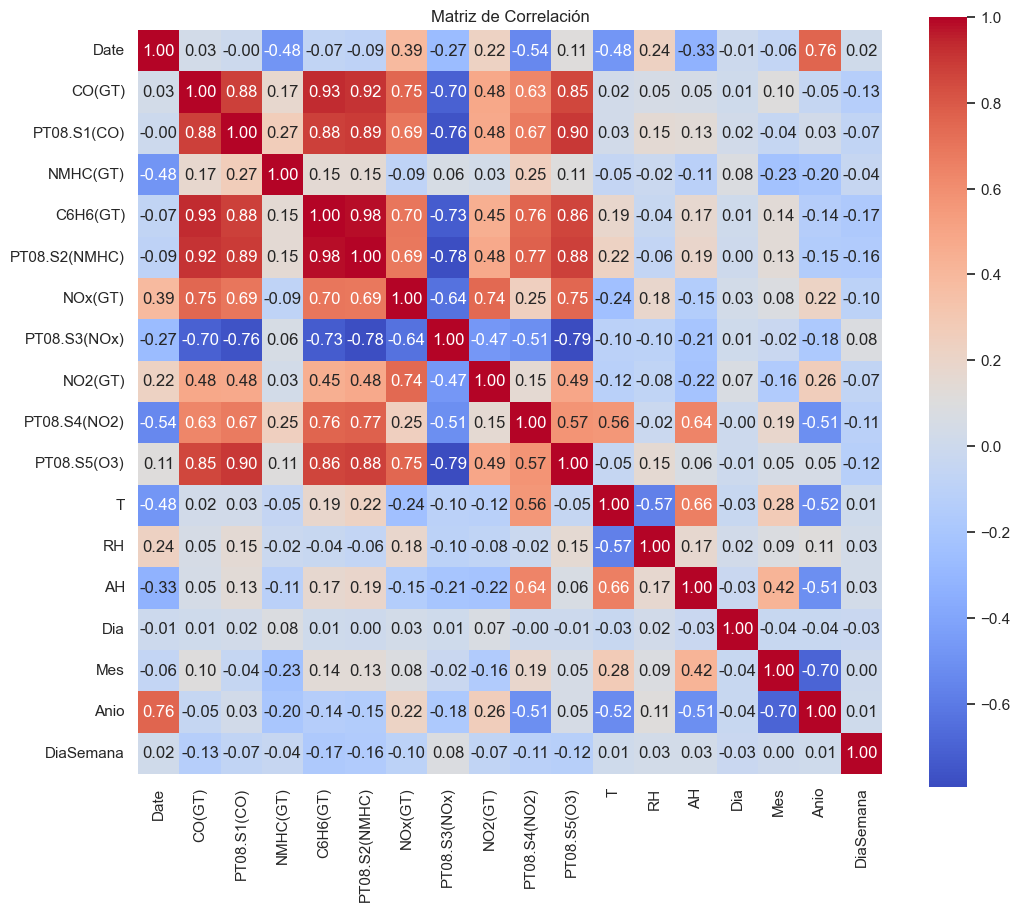

In [17]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

### **Análisis de la Matriz de Correlación**

El análisis de correlación revela relaciones significativas entre las variables, destacando las siguientes observaciones clave:

#### Relaciones Fuertes Positivas

- **CO(GT):**
  - Alta correlación con `PT08.S1(CO)` (0.88), `C6H6(GT)` (0.93), y `PT08.S2(NMHC)` (0.91).
  - También correlaciona bien con `PT08.S5(O3)` (0.85), lo que indica que estas variables están relacionadas con emisiones y niveles de contaminantes.

- **C6H6(GT)** y **PT08.S2(NMHC):**
  - Tienen correlaciones fuertes entre sí y con otras medidas como `PT08.S1(CO)` y `PT08.S5(O3)`.

#### Relaciones Fuertes Negativas

- **PT08.S3(NOx):**
  - Correlación negativa significativa con varias variables, como `CO(GT)` (-0.70) y `PT08.S1(CO)` (-0.76), sugiriendo una posible relación inversa entre estos sensores y los niveles de NOx.

#### Relaciones Menores con Factores Ambientales

- **T (temperatura)** y **AH (humedad absoluta):**
  - Correlación moderada entre sí (0.66), pero no afectan significativamente las concentraciones de contaminantes, salvo algunas relaciones menores.


### **Rango Intercuartílico (IQR)**

El IQR se calcula como la diferencia entre el tercer cuartil (75%) y el primer cuartil (25%) de una columna numérica. Este rango captura la dispersión central de los datos, excluyendo posibles valores extremos.

### Identificación de Límites

Se establecen límites superior e inferior para detectar valores extremos. Estos límites se calculan como sigue:
- Límite inferior: una distancia de 1.5 veces el IQR por debajo del primer cuartil.
- Límite superior: una distancia de 1.5 veces el IQR por encima del tercer cuartil.

### Detección de Valores Atípicos

Los datos que se encuentran por debajo del límite inferior o por encima del límite superior se consideran valores atípicos. Estos se identifican para cada columna relevante del conjunto de datos.

### Resultados y Análisis

Se registra la cantidad de valores extremos detectados por columna, junto con los límites calculados. Esta información permite evaluar la presencia e impacto de los outliers en el conjunto de datos.

In [18]:
# Definir una función para detectar outliers usando el rango intercuartílico (IQR)
def detectar_outliers(df_cleaned, columnas):
    outliers_info = {}
    for columna in columnas:
        Q1 = df[columna].quantile(0.25)  # Primer cuartil (25%)
        Q3 = df[columna].quantile(0.75)  # Tercer cuartil (75%)
        IQR = Q3 - Q1  # Rango intercuartílico

        # Límites para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Identificar valores fuera de los límites
        outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
        outliers_info[columna] = {
            "Cantidad de outliers": len(outliers),
            "Límite inferior": limite_inferior,
            "Límite superior": limite_superior
        }
    return outliers_info

# Aplicar la función a las columnas numéricas de tu DataFrame
columnas_numericas = df.select_dtypes(include=[np.number]).columns
outliers = detectar_outliers(df, columnas_numericas)

# Mostrar resultados
for columna, info in outliers.items():
    print(f"Columna: {columna}")
    print(f" - Cantidad de outliers: {info['Cantidad de outliers']}")
    print(f" - Límite inferior: {info['Límite inferior']}")
    print(f" - Límite superior: {info['Límite superior']}")
    print()

Columna: CO(GT)
 - Cantidad de outliers: 1898
 - Límite inferior: -2.4
 - Límite superior: 5.6

Columna: PT08.S1(CO)
 - Cantidad de outliers: 484
 - Límite inferior: 471.0
 - Límite superior: 1671.0

Columna: NMHC(GT)
 - Cantidad de outliers: 914
 - Límite inferior: -200.0
 - Límite superior: -200.0

Columna: C6H6(GT)
 - Cantidad de outliers: 606
 - Límite inferior: -10.399999999999999
 - Límite superior: 28.0

Columna: PT08.S2(NMHC)
 - Cantidad de outliers: 426
 - Límite inferior: 120.0
 - Límite superior: 1696.0

Columna: NOx(GT)
 - Cantidad de outliers: 509
 - Límite inferior: -301.0
 - Límite superior: 635.0

Columna: PT08.S3(NOx)
 - Cantidad de outliers: 602
 - Límite inferior: 152.5
 - Límite superior: 1444.5

Columna: NO2(GT)
 - Cantidad de outliers: 1696
 - Límite inferior: -67.0
 - Límite superior: 253.0

Columna: PT08.S4(NO2)
 - Cantidad de outliers: 450
 - Límite inferior: 469.5
 - Límite superior: 2377.5

Columna: PT08.S5(O3)
 - Cantidad de outliers: 458
 - Límite inferior:

### **Tramatamiento de los datos**

### Selección de Columnas Numéricas

Se identifican y seleccionan exclusivamente las columnas que contienen valores numéricos. Esto es esencial porque el cálculo de Z-scores y las operaciones matemáticas posteriores solo pueden realizarse sobre datos numéricos.

### Verificación y Limpieza de Valores Nulos

Se eliminan las filas que contienen valores nulos en las columnas numéricas seleccionadas. Esto asegura que el cálculo de Z-scores sea preciso y que no se produzcan errores debido a datos faltantes.

### Conversión de Tipos de Datos

Todas las columnas numéricas se convierten explícitamente al tipo de dato float para garantizar compatibilidad con el cálculo de Z-scores.

### Cálculo de Z-scores

Los Z-scores se calculan para cada valor en las columnas numéricas. Un Z-score mide cuántas desviaciones estándar está un valor por encima o por debajo de la media. Este cálculo se realiza de forma absoluta para facilitar la comparación con un umbral predefinido.

### Creación de un Filtro para Outliers

Se establece un umbral para los Z-scores, de manera que cualquier fila cuyos valores numéricos tengan Z-scores superiores a este umbral sea considerada como un outlier. Las filas que cumplen con el criterio de tener todos sus Z-scores dentro del rango aceptable se retienen.

### Creación de un DataFrame Sin Outliers

Se crea un nuevo conjunto de datos que excluye las filas consideradas como outliers. Esto permite trabajar con datos más representativos y menos influenciados por valores extremos.

### Inspección del DataFrame Limpio

Se realiza un análisis básico del conjunto de datos limpio:
- Se compara el número de filas y columnas antes y después de la eliminación de outliers.
- Se visualizan las primeras filas del conjunto de datos limpio para verificar su estado.
- Se genera un resumen estadístico del DataFrame limpio, que incluye medidas como la media, desviación estándar y percentiles.

In [19]:
# Seleccionar columnas estrictamente numéricas
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Verificar que no hay valores nulos en las columnas seleccionadas
df = df.dropna(subset=columnas_numericas)

# Convertir todas las columnas numéricas a float para evitar errores con zscore
df[columnas_numericas] = df[columnas_numericas].astype(float)

# Calcular Z-scores para las columnas numéricas
zscores = np.abs(zscore(df[columnas_numericas]))

# Crear un filtro para las filas donde todos los Z-scores son menores que el umbral (5)
filtro = (zscores < 5).all(axis=1)

# Crear un nuevo DataFrame eliminando las filas que tienen outliers
df_sin_outliers = df[filtro]

# Mostrar información del DataFrame limpio
print("Antes de eliminar outliers:")
print(f"Filas: {len(df)}, Columnas: {len(df.columns)}")

print("\nDespués de eliminar outliers:")
print(f"Filas: {len(df_sin_outliers)}, Columnas: {len(df_sin_outliers.columns)}")

# Mostrar las primeras filas del DataFrame limpio
print("\nPrimeras filas del DataFrame sin outliers:")
print(df_sin_outliers.head())

print(df_sin_outliers.describe())

Antes de eliminar outliers:
Filas: 9357, Columnas: 18

Después de eliminar outliers:
Filas: 9270, Columnas: 18

Primeras filas del DataFrame sin outliers:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            939      131   
3 2004-03-10       2         1376        80         9            948      172   
4 2004-03-10       2         1272        51         6            836      131   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  T  RH  AH  Dia  Mes  \
0          1056      113          1692         1268 14  49   1   10    3   
1          1174       92          1559          972 13  48   1   10    3   
2          1140      114          1555         1074 12  54   1   10    3   
3          1092      122          1584         1203 11

# **Definición de Predictores y Objetivos**
Se definen las variables predictoras y las variables objetivo que se utilizarán en el análisis o modelado.

## Predictores
- Los **predictores** son las variables independientes, también conocidas como **features** o características.
- Representan los datos que se utilizarán como entrada para realizar predicciones.
- En este caso, los predictores seleccionados son:
  - **T**: Temperatura.
  - **RH**: Humedad relativa.
  - **AH**: Humedad absoluta.

## Objetivos
- Los **objetivos** son las variables dependientes o **targets**.
- Representan los valores que queremos predecir o explicar utilizando los predictores.
- En este caso, los objetivos seleccionados son:
  - **PT08.S1(CO)**: Concentración medida por un sensor relacionado con CO (monóxido de carbono).
  - **PT08.S2(NMHC)**: Concentración medida por un sensor relacionado con compuestos no metánicos (NMHC).
  - **PT08.S3(NOx)**: Concentración medida por un sensor relacionado con óxidos de nitrógeno (NOx).
  - **PT08.S4(NO2)**: Concentración medida por un sensor relacionado con dióxido de nitrógeno (NO2).

## División en Variables Predictoras y Objetivo
- Las variables se dividen en dos conjuntos principales:
  - `X`: Contiene las variables predictoras, seleccionadas de las columnas del conjunto de datos limpio (`df_cleaned`) correspondientes a **T**, **RH** y **AH**.
  - `y`: Contiene las variables objetivo, seleccionadas de las columnas correspondientes a los sensores mencionados.

Esta separación es esencial para entrenar modelos predictivos, ya que `X` proporciona la información utilizada para hacer predicciones, y `y` se usa como referencia para evaluar la precisión del modelo.


In [20]:
# Definir predictores y objetivos
predictors = ['T', 'RH', 'AH']
targets = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']

X = df_sin_outliers[predictors]
y = df_sin_outliers[targets]

### **Normalización y Separación de los Datos**
En este paso, se realizan dos tareas fundamentales para preparar los datos para su uso en un modelo de aprendizaje automático: **normalización** y **división en conjuntos de entrenamiento y prueba**.

### Normalización
La normalización es un proceso que ajusta los valores de las variables predictoras para que estén dentro de un rango común, generalmente entre 0 y 1. Esto es especialmente importante cuando las variables tienen escalas muy diferentes, ya que ayuda a que los modelos de aprendizaje automático converjan más rápido y de manera más eficiente.

1. Se utilizó el objeto `MinMaxScaler` de la biblioteca `sklearn`, que escala cada característica a un rango entre 0 y 1.
2. El método `fit_transform` se aplicó a las variables predictoras (`X`), ajustando los datos al rango deseado y transformándolos en consecuencia.
3. El resultado, almacenado en `X_scaled`, es una versión escalada de las variables predictoras.


### División en Conjuntos de Entrenamiento y Prueba
Después de la normalización, los datos se dividen en dos subconjuntos:
- **Conjunto de entrenamiento**: Se utiliza para entrenar el modelo.
- **Conjunto de prueba**: Se utiliza para evaluar el rendimiento del modelo con datos que no ha visto antes.

### ¿Cómo se realizó la división?
1. Se utilizó la función `train_test_split` de `sklearn`:
   - `X_scaled`: Variables predictoras ya normalizadas.
   - `y`: Variables objetivo.
2. Se especificó una proporción del 20% para el conjunto de prueba (`test_size=0.2`), lo que significa que el 80% de los datos se utilizarán para el entrenamiento y el 20% para la validación.
3. El argumento `random_state=42` asegura que la división sea reproducible, permitiendo obtener los mismos resultados en ejecuciones futuras.

### Resultado de la división:
- **`X_train` y `y_train`**: Datos de entrenamiento (80% del total).
- **`X_test` y `y_test`**: Datos de prueba (20% del total).


### Importancia de estos pasos
1. **Normalización**: Ayuda a mejorar el rendimiento de los modelos al garantizar que todas las variables estén en la misma escala.
2. **División en conjuntos de entrenamiento y prueba**: Permite evaluar el modelo de manera justa con datos que no ha visto durante el entrenamiento, evitando el sobreajuste.


In [21]:
# normalización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Separar datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### **Definición y Configuración de los Modelos**

En esta sección, se define una variedad de modelos de regresión y sus respectivos hiperparámetros para realizar experimentos y comparar su rendimiento.

### Modelos Incluidos
Se seleccionaron diferentes algoritmos de regresión que cubren múltiples enfoques y técnicas.

1. **Regresión Lineal (Linear Regression)**:
   - Modelo simple basado en la relación lineal entre las variables predictoras y el objetivo.
   - No requiere hiperparámetros.

2. **Árbol de Decisión (Decision Tree Regressor)**:
   - Modelo basado en divisiones secuenciales de los datos según características relevantes.
   - Hiperparámetros:
     - `max_depth`: Profundidad máxima del árbol.
     - `min_samples_split`: Número mínimo de muestras necesarias para dividir un nodo.

3. **Bosque Aleatorio (Random Forest Regressor)**:
   - Ensamble de múltiples árboles de decisión que promedian los resultados para mejorar la precisión.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el bosque.
     - `max_depth`: Profundidad máxima de los árboles.
     - `min_samples_split`: Requisito mínimo de muestras para dividir nodos.

4. **Gradient Boosting Regressor**:
   - Modelo de ensamble que ajusta secuencialmente árboles para minimizar el error residual.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el ensamble.
     - `learning_rate`: Tasa de aprendizaje que controla el impacto de cada árbol.
     - `max_depth`: Profundidad máxima de los árboles.

5. **Regresor de Vectores de Soporte (Support Vector Regressor - SVR)**:
   - Modelo que encuentra un hiperplano en un espacio dimensional alto para realizar predicciones.
   - Hiperparámetros:
     - `C`: Penalización de errores (regularización).
     - `kernel`: Tipo de núcleo para transformar los datos (e.g., `linear`, `rbf`).
     - `epsilon`: Margen de tolerancia alrededor del hiperplano.

6. **XGBoost Regressor**:
   - Modelo avanzado basado en gradient boosting que incluye optimizaciones de regularización.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles.
     - `learning_rate`: Tasa de aprendizaje.
     - `max_depth`: Profundidad máxima de los árboles.
     - `subsample`: Fracción de datos utilizada en cada iteración.

7. **Red Neuronal (Neural Network - MLPRegressor)**:
   - Modelo inspirado en la estructura del cerebro humano, útil para capturar relaciones no lineales complejas.
   - Hiperparámetros:
     - `hidden_layer_sizes`: Configuración del número de neuronas en cada capa oculta.
     - `activation`: Función de activación (`relu`, `tanh`).
     - `solver`: Algoritmo de optimización (`adam`, `sgd`).
     - `learning_rate`: Estrategia para ajustar la tasa de aprendizaje (`constant`, `adaptive`).


### Configuración de los Modelos
- Cada modelo se define junto con un conjunto de posibles valores para sus hiperparámetros, organizados en un diccionario llamado `param_grids`.
- Este diccionario permite automatizar la búsqueda de combinaciones óptimas de hiperparámetros mediante técnicas como la búsqueda en malla (grid search) o búsqueda aleatoria (random search).

### Resultados
- Se crea un diccionario vacío llamado `results` que será utilizado para almacenar los resultados de cada modelo y las combinaciones de hiperparámetros evaluados.
- Esto facilita la comparación y selección del modelo más adecuado según los datos y la métrica de evaluación seleccionada.

### Importancia de este Enfoque
1. **Diversidad de Modelos**:
   - Permite probar múltiples enfoques para identificar el más adecuado para el problema.
   
2. **Optimización de Hiperparámetros**:
   - La configuración de hiperparámetros es clave para maximizar el rendimiento de cada modelo.

3. **Flexibilidad**:
   - Facilita la experimentación y la posibilidad de extender el análisis a otros algoritmos en el futuro.



In [22]:

# Definir modelos y sus hiperparámetros
param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

results = {}


### **Optimización, Evaluación y Comparación de Modelos**
En esta sección, se lleva a cabo la optimización de hiperparámetros, el entrenamiento y la evaluación de diferentes modelos de regresión para cada variable objetivo. Además, se visualizan los resultados y se analizan métricas clave como el MSE, el R² y el sobreajuste.

### Optimización de Hiperparámetros
1. **Selección de Variable Objetivo**:
   - Cada modelo se entrena y evalúa individualmente para cada una de las variables objetivo definidas anteriormente (e.g., `PT08.S1(CO)`).

2. **Configuración de `GridSearchCV`**:
   - Se utiliza `GridSearchCV` para realizar una búsqueda exhaustiva de las mejores combinaciones de hiperparámetros para cada modelo.
   - Configuraciones clave:
     - `cv=5`: Validación cruzada con 5 particiones.
     - `scoring='neg_mean_squared_error'`: Métrica de evaluación basada en el MSE.
     - `n_jobs=-1`: Uso de todos los núcleos disponibles para acelerar el proceso.

3. **Entrenamiento y Selección del Mejor Modelo**:
   - Para cada combinación de hiperparámetros, `GridSearchCV` ajusta el modelo y evalúa su desempeño.
   - Se selecciona el modelo con el menor error cuadrático medio (MSE).

### Evaluación de los Modelos
1. **Predicciones**:
   - Los modelos seleccionados generan predicciones para los conjuntos de entrenamiento y prueba.
2. **Cálculo de Métricas**:
   - **MSE** (Mean Squared Error):
     - Mide el promedio de los errores al cuadrado.
     - Cuanto menor sea el valor, mejor es el modelo.
   - **R²** (Coeficiente de Determinación):
     - Indica la proporción de la varianza explicada por el modelo.
     - Valores más cercanos a 1 indican mejor desempeño.
3. **Análisis de Sobreajuste**:
   - Se calcula la diferencia entre el R² de entrenamiento y el de prueba para medir el nivel de sobreajuste.

### Almacenamiento y Visualización de Resultados
### Resultados Consolidados
- Se crea un DataFrame (`results_df`) que organiza los resultados de cada modelo y variable objetivo:
  - Métricas de entrenamiento y prueba (MSE y R²).
  - Hiperparámetros seleccionados.
  - Diferencia entre R² de entrenamiento y prueba (indicador de sobreajuste).

### Visualizaciones
1. **Nivel de Sobreajuste**:
   - Gráfico de barras que muestra la diferencia entre el R² de entrenamiento y prueba para cada modelo y variable objetivo.
   - Ayuda a identificar modelos que podrían estar ajustando en exceso los datos de entrenamiento.

2. **Comparación de R²**:
   - Gráfico de barras que compara el R² de prueba de cada modelo para cada variable objetivo.
   - Permite identificar qué modelos explican mejor la varianza de los datos.

3. **Comparación de MSE**:
   - Gráfico de barras que muestra los valores de MSE de prueba para cada modelo y variable objetivo.
   - Los valores más bajos indican un mejor desempeño.

### Importancia del Análisis
1. **Optimización Eficiente**:
   - `GridSearchCV` permite probar combinaciones de hiperparámetros de manera eficiente y sistemática.
   
2. **Evaluación Completa**:
   - El uso de múltiples métricas (MSE y R²) proporciona una evaluación integral del desempeño de los modelos.

3. **Detección de Sobreajuste**:
   - El análisis de sobreajuste garantiza que los modelos seleccionados generalicen bien a datos no vistos.

4. **Visualización Intuitiva**:
   - Los gráficos facilitan la comparación de modelos y métricas clave, ayudando en la toma de decisiones.

In [23]:
# Entrenar y evaluar cada modelo por variable objetivo
for target in targets:
    print(f"\nOptimización de hiperparámetros para el objetivo: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    results[target] = {}
    
    for name, config in param_grids.items():
        model = config['model']
        params = config['params']
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train_target)
        
        # Mejor modelo y evaluación
        best_model = grid_search.best_estimator_
        
        # Predicciones en entrenamiento y prueba
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calcular métricas
        mse_train = mean_squared_error(y_train_target, y_train_pred)
        mse_test = mean_squared_error(y_test_target, y_test_pred)
        r2_train = r2_score(y_train_target, y_train_pred)
        r2_test = r2_score(y_test_target, y_test_pred)
        
        # Guardar resultados
        results[target][name] = {
            'Best Params': grid_search.best_params_,
            'MSE Train': mse_train,
            'MSE Test': mse_test,
            'R2 Train': r2_train,
            'R2': r2_test  # R2 de prueba
        }
        print(f"{name} mejor MSE: {mse_test:.4f}, R2: {r2_test:.4f}, Hiperparámetros: {grid_search.best_params_}")


Optimización de hiperparámetros para el objetivo: PT08.S1(CO)
Linear Regression mejor MSE: 42705.4774, R2: 0.5888, Hiperparámetros: {}
Decision Tree mejor MSE: 44194.2697, R2: 0.5745, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10}
Random Forest mejor MSE: 39994.8968, R2: 0.6149, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting mejor MSE: 40842.9495, R2: 0.6068, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Support Vector Regressor mejor MSE: 43818.6461, R2: 0.5781, Hiperparámetros: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
XGBoost mejor MSE: 40521.8210, R2: 0.6099, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/pyth

Neural Network mejor MSE: 43039.9752, R2: 0.5856, Hiperparámetros: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}

Optimización de hiperparámetros para el objetivo: PT08.S2(NMHC)
Linear Regression mejor MSE: 63775.5528, R2: 0.4384, Hiperparámetros: {}
Decision Tree mejor MSE: 70894.5108, R2: 0.3757, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 5}
Random Forest mejor MSE: 61190.9942, R2: 0.4611, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting mejor MSE: 61886.7258, R2: 0.4550, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Support Vector Regressor mejor MSE: 65246.4727, R2: 0.4254, Hiperparámetros: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
XGBoost mejor MSE: 61360.3379, R2: 0.4597, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/pyth

Neural Network mejor MSE: 63967.7603, R2: 0.4367, Hiperparámetros: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

Optimización de hiperparámetros para el objetivo: PT08.S3(NOx)
Linear Regression mejor MSE: 56293.4579, R2: 0.4215, Hiperparámetros: {}
Decision Tree mejor MSE: 60746.9154, R2: 0.3757, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10}
Random Forest mejor MSE: 53502.5077, R2: 0.4502, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting mejor MSE: 53350.6659, R2: 0.4517, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Support Vector Regressor mejor MSE: 57239.0150, R2: 0.4118, Hiperparámetros: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
XGBoost mejor MSE: 53164.1984, R2: 0.4536, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/pyth

Neural Network mejor MSE: 59492.8777, R2: 0.3886, Hiperparámetros: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}

Optimización de hiperparámetros para el objetivo: PT08.S4(NO2)
Linear Regression mejor MSE: 61358.2987, R2: 0.7067, Hiperparámetros: {}
Decision Tree mejor MSE: 62004.1582, R2: 0.7036, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10}
Random Forest mejor MSE: 54901.1023, R2: 0.7376, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting mejor MSE: 55040.8512, R2: 0.7369, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Support Vector Regressor mejor MSE: 62168.8550, R2: 0.7028, Hiperparámetros: {'C': 10, 'epsilon': 1, 'kernel': 'rbf'}
XGBoost mejor MSE: 54725.6755, R2: 0.7384, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/pyth

Neural Network mejor MSE: 64330.5951, R2: 0.6925, Hiperparámetros: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


### **Conversión de Resultados a un DataFrame**

Se recopilan los resultados de diferentes modelos y métricas en un DataFrame. Esto facilita la organización y la visualización de los datos. Para cada combinación de modelo y variable objetivo, se registran:
- Métricas de error (MSE) tanto para el conjunto de entrenamiento como de prueba.
- Coeficientes de determinación (R²) para evaluar el ajuste de los modelos.
- Una medida de sobreajuste calculada como la diferencia entre R² de entrenamiento y prueba.
- Los mejores hiperparámetros identificados para cada modelo.

El DataFrame resultante permite analizar el rendimiento de los modelos de manera estructurada y comparativa.

### Configuración de Estilo para Visualizaciones

Se utiliza un estilo de gráficos basado en rejillas para mejorar la legibilidad y la presentación. Esto es especialmente útil para comparar visualmente el rendimiento de diferentes modelos.

### Gráfico de R²

Se crea un gráfico de barras para comparar el R² obtenido por cada modelo en las distintas variables objetivo. Esto ayuda a identificar qué modelos tienen mejor capacidad de explicación en el conjunto de prueba.

### Gráfico de MSE

gráfico de barras muestra el MSE en el conjunto de prueba. Este gráfico destaca el nivel de error absoluto de las predicciones y permite comparar el rendimiento relativo de los modelos.

### Gráfico de Sobreajuste

El último gráfico analiza el nivel de sobreajuste, medido como la diferencia entre el R² de entrenamiento y prueba. Esto permite evaluar si un modelo está ajustando demasiado los datos de entrenamiento y no generaliza bien a datos nuevos.

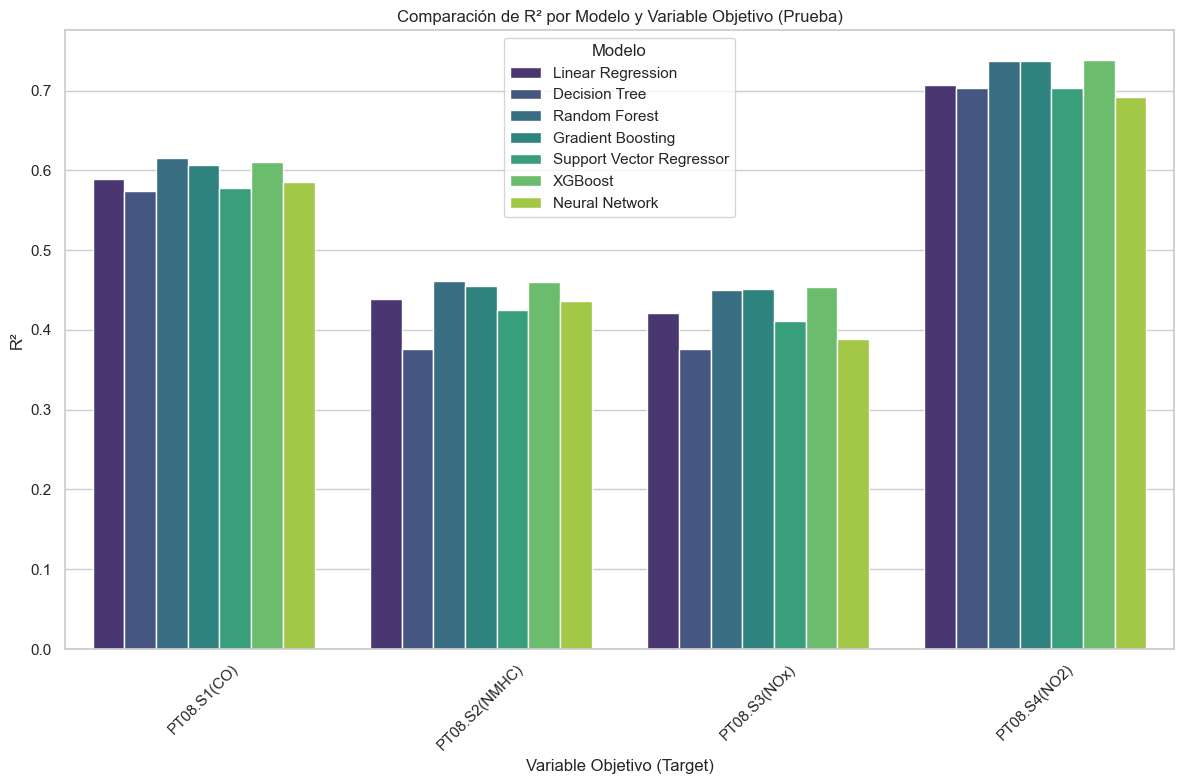

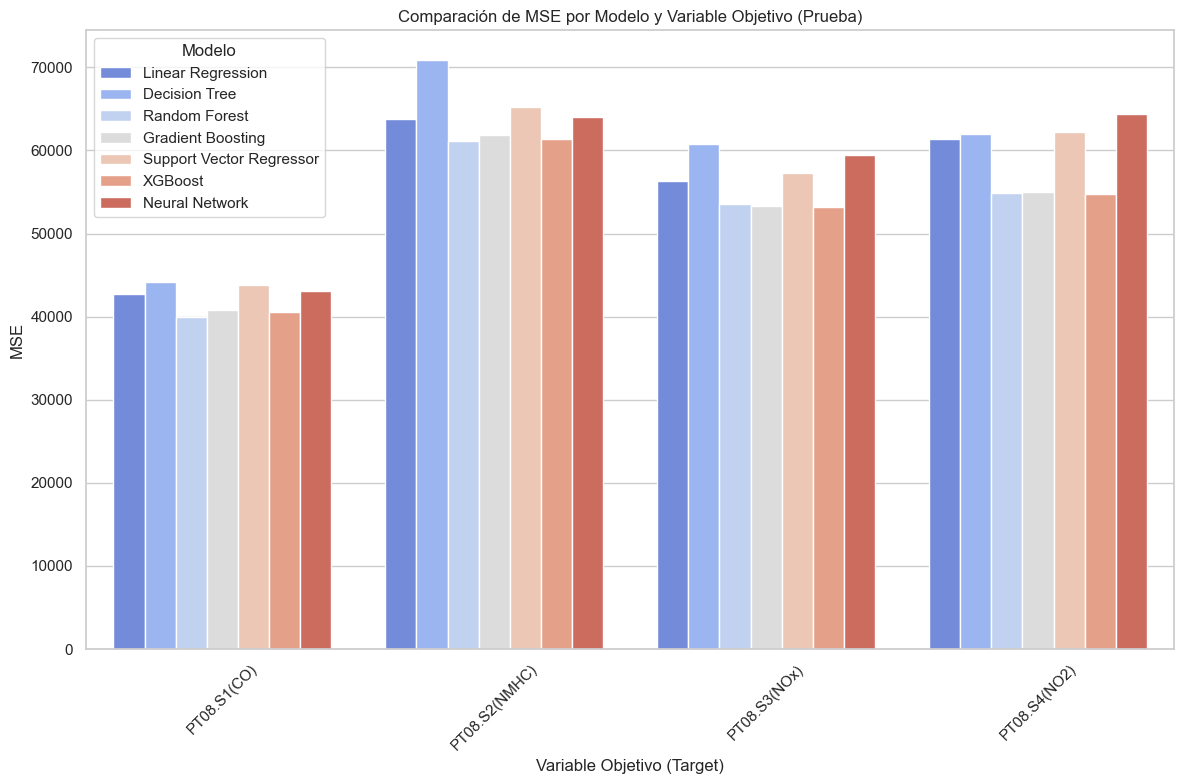

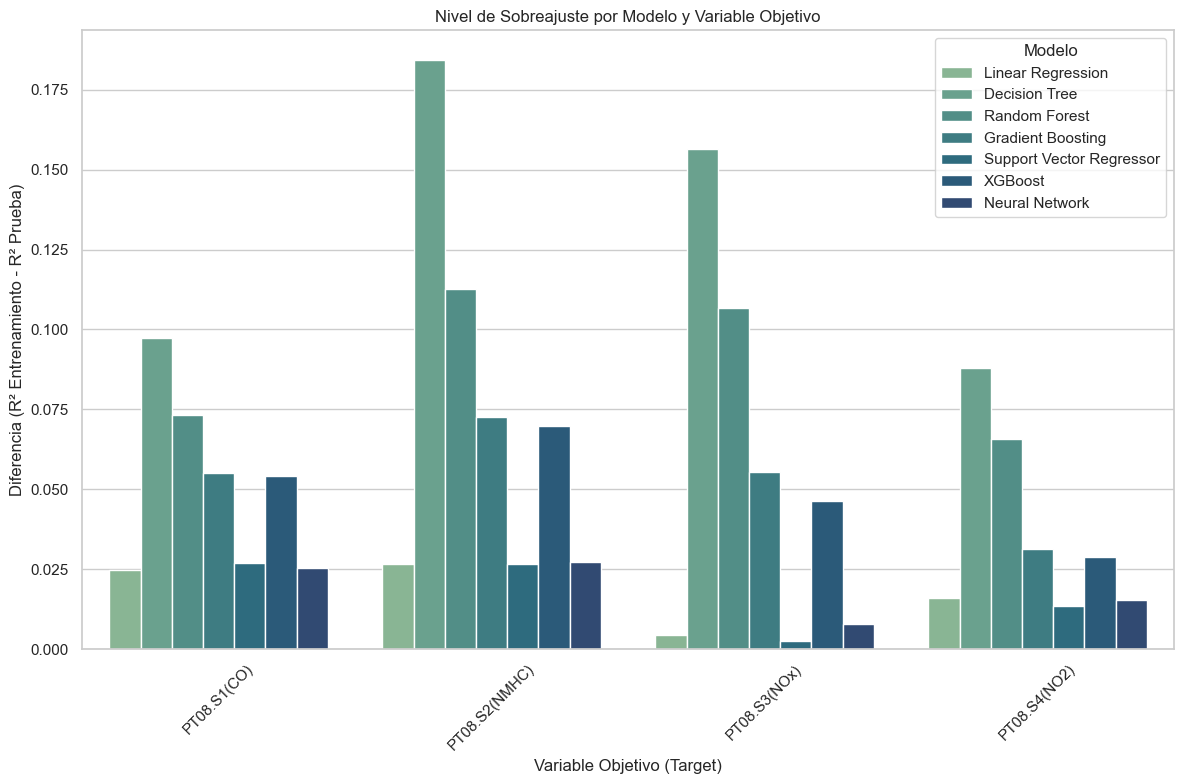

In [24]:
# Convertir los resultados en un DataFrame para facilitar la visualización
rows = []
for target, metrics in results.items():
    for name, scores in metrics.items():
        rows.append({
            'Target': target,
            'Model': name,
            'MSE Train': scores['MSE Train'],
            'MSE Test': scores['MSE Test'],
            'R2 Train': scores['R2 Train'],
            'R2 Test': scores['R2'],  # R2 de prueba
            'Overfitting': scores['R2 Train'] - scores['R2'],  # Calcular sobreajuste
            'Best Params': scores['Best Params']
        })

results_df = pd.DataFrame(rows)

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de R² (entrenamiento vs prueba)
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='R2 Test', hue='Model', palette='viridis')
plt.title("Comparación de R² por Modelo y Variable Objetivo (Prueba)")
plt.ylabel("R²")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de MSE (entrenamiento vs prueba)
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='MSE Test', hue='Model', palette='coolwarm')
plt.title("Comparación de MSE por Modelo y Variable Objetivo (Prueba)")
plt.ylabel("MSE")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de sobreajuste
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='Overfitting', hue='Model', palette='crest')
plt.title("Nivel de Sobreajuste por Modelo y Variable Objetivo")
plt.ylabel("Diferencia (R² Entrenamiento - R² Prueba)")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Conclusión final**
- Variables como `C6H6(GT)`, `PT08.S1(CO)` y `PT08.S2(NMHC)` demostraron ser altamente relevantes como predictores de otros contaminantes.

#### Modelos Evaluados
- Se aplicaron múltiples modelos de regresión (`Linear Regression`, `Decision Tree`, `Random Forest`, `Gradient Boosting`, `SVR`, `XGBoost`, y Redes Neuronales) para predecir variables objetivo relacionadas con la calidad del aire.
- El uso de `GridSearchCV` optimizó los hiperparámetros, asegurando el mejor rendimiento para cada modelo.

- `Random Forest` y `Gradient Boosting` destacaron como los modelos más consistentes en términos de precisión y generalización, siendo ideales para el análisis predictivo de la calidad del aire.

- Los modelos como `Decision Tree` y `Neural Network` requieren ajustes adicionales para reducir el sobreajuste y mejorar la robustez en el conjunto de prueba.

#### Gráficos

- **Gráfico de R² (entrenamiento vs prueba):**
  - Modelos como `Random Forest` y `Gradient Boosting` demostraron un buen equilibrio entre precisión y capacidad de generalización.
  - Algunos modelos como `Linear Regression` mostraron limitaciones en su capacidad predictiva para ciertas variables.

- **Gráfico de MSE (entrenamiento vs prueba):**
  - Los errores más bajos correspondieron a los modelos ensamble (`Random Forest` y `XGBoost`), destacando su capacidad para manejar la complejidad del conjunto de datos.

- **Gráfico de Sobreajuste:**
  - Modelos como `Decision Tree` y `SVR` mostraron un mayor nivel de sobreajuste, indicando que podrían no generalizar bien a datos nuevos.

PARTE DE MIA IMANOL

In [25]:
import joblib

# Cargar el modelo en Python 3
model = joblib.load('modelo_xgb_optimizado.pkl')

# Guardarlo nuevamente en un formato compatible con Python 2 (protocolo 2)
joblib.dump(model, 'modelo_xgb_optimizado_v2.pkl', protocol=2)

['modelo_xgb_optimizado_v2.pkl']